<a href="https://colab.research.google.com/github/zyberg2091/Flight-Delay-Prediction/blob/master/Real_or_Not_NLP_with_Disaster_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#using EDA,BiLSTMs
import tensorflow as tf
import pandas as pd
import numpy as np

from tensorflow.keras.layers import Input,Dense,Dropout,Bidirectional,LSTM,Embedding,GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from wordcloud import WordCloud, STOPWORDS

In [ ]:
import csv
with open('/content/test.csv', 'r') as f:
  file=csv.reader(f)
  for row in file:
    print(row)
    break

['id', 'keyword', 'location', 'text']


In [ ]:
df=pd.read_csv("train.csv")
df1=pd.read_csv("test.csv")
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
#find the the most common words in the tweets
#using wordcloud
stopwords = set(STOPWORDS)
def word_cloud(data,title=None):
    cloud = WordCloud(background_color = 'black',
                     stopwords = stopwords,
                     max_words = 200,
                     max_font_size = 40,
                     scale = 3).generate(str(data))
    fig = plt.figure(figsize=(15,15))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.25)
        plt.imshow(cloud)
        plt.show()


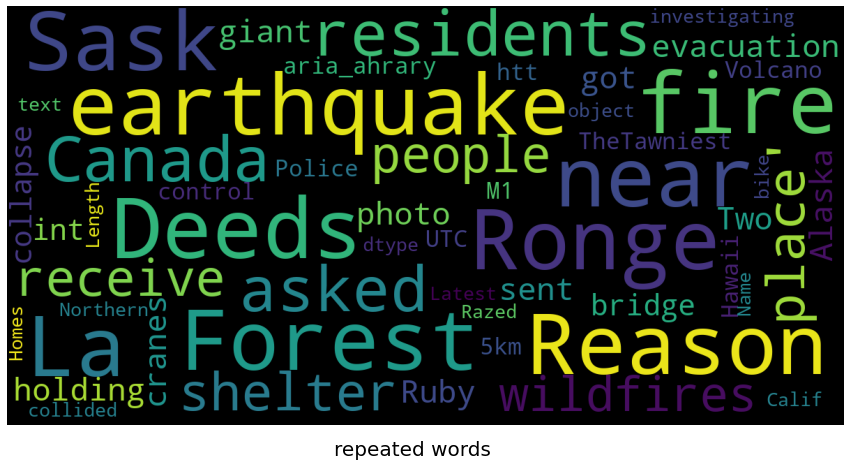

In [ ]:
word_cloud(df['text'],'repeated words')

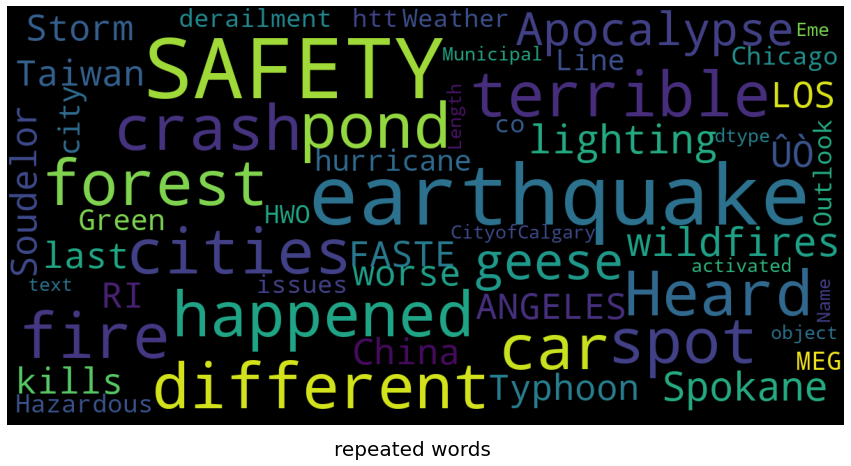

In [ ]:
word_cloud(df1['text'],'repeated words')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


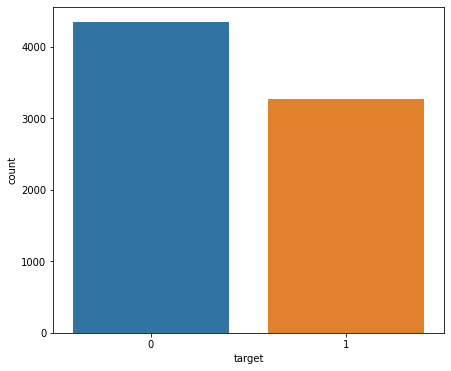

In [ ]:
import seaborn as sns
plt.figure(figsize=(7,6))
sns.countplot(df['target'])

In [ ]:
import re

In [ ]:
#data cleaning

def remove_emoji(text):
  emoji_pattern=re.compile("["
        u"\U0001F600-\U0001F64F"                             # emoticons
        u"\U0001F300-\U0001F5FF"                             # symbols & pictographs
        u"\U0001F680-\U0001F6FF"                             # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"                             # flags (iOS)
                           "]+", flags=re.UNICODE)
  return emoji_pattern.sub(r'', text)                       # no emoji

In [ ]:
df['text']=df['text'].apply(lambda x:remove_emoji(x))
df1['text']=df1['text'].apply(lambda x:remove_emoji(x))

In [ ]:
def clean_text(data):
  data=re.sub(r'https?://\S+|www\.\S+',' ',data)
  t = [w for w in data.split() if w not in stopwords]
  data = ' '.join(t)
  data = data.lower()
  data = re.sub('[^a-zA-Z]',' ', data)

  return data

In [ ]:
df['text']=df['text'].apply(lambda x:clean_text(x))
df1['text']=df1['text'].apply(lambda x:clean_text(x))


In [ ]:
x_train=df.iloc[:,3].values
y_train=df.iloc[:,4].values

In [ ]:
x_train.shape

(7613,)

In [ ]:
x_train[:2],y_train[:2]

(array(['our deeds reason  earthquake may allah forgive us',
        'forest fire near la ronge sask  canada'], dtype=object),
 array([1, 1]))

In [ ]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(x_train)
sequences=tokenizer.texts_to_sequences(x_train)
word_index=tokenizer.word_index

In [ ]:
sequences[:2]

[[561, 4387, 796, 195, 79, 1530, 4388, 32],
 [130, 8, 167, 668, 6493, 6494, 1138]]

In [ ]:
vocab_size=len(word_index)

In [ ]:
value=max([i for x in x_train for i in range(len(x.split()))])

In [ ]:
value

27

In [ ]:
x_pad=pad_sequences(sequences,maxlen=value,padding='post')


In [ ]:
y_train.shape

(7613,)

In [ ]:
T=x_pad.shape[1]

In [ ]:
#Glove embedding

!wget --no-check-certificate \https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
-O /tmp/glove.6B.100d.txt

embedding_dim=100

embedding_index={}
with open("/tmp/glove.6B.100d.txt") as f:
  for line in f:
    val=line.split()
    word=val[0]
    word_ind=np.asarray(val[1:],dtype='float32')
    embedding_index[word]=word_ind

embedding_matrix = np.zeros((vocab_size+1, embedding_dim))
for w,t in word_index.items():
  embedding_vector=embedding_index.get(w)
  if embedding_vector is not None:
    embedding_matrix[t]=embedding_vector




--2020-07-31 12:58:11--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.128, 172.217.203.128, 173.194.210.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M  91.3MB/s    in 3.6s    

2020-07-31 12:58:15 (91.3 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [ ]:
#architecture

i=Input(shape=(T,))
x=Embedding(vocab_size+1,embedding_dim,weights=[embedding_matrix], trainable=False)(i)
x=Bidirectional(LSTM(128,return_sequences=True))(x)
x=GlobalMaxPooling1D()(x)
x=Dense(64,activation='relu')(x)
x=Dropout(0.2)(x)
x=Dense(1,activation='sigmoid')(x)

model=Model(i,x)

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 27)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 27, 100)           1621000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 27, 256)           234496    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65  

In [ ]:


r=model.fit(x_pad,y_train,validation_split=0.2,epochs=10)



Epoch 1/10
191/191 [==============================] - 12s 65ms/step - loss: 0.4780 - accuracy: 0.7824 - val_loss: 0.4178 - val_accuracy: 0.8116
Epoch 2/10
191/191 [==============================] - 12s 61ms/step - loss: 0.4226 - accuracy: 0.8190 - val_loss: 0.4241 - val_accuracy: 0.8116
Epoch 3/10
191/191 [==============================] - 12s 61ms/step - loss: 0.3868 - accuracy: 0.8333 - val_loss: 0.4205 - val_accuracy: 0.8089
Epoch 4/10
191/191 [==============================] - 12s 61ms/step - loss: 0.3559 - accuracy: 0.8525 - val_loss: 0.4105 - val_accuracy: 0.8109
Epoch 5/10
191/191 [==============================] - 12s 61ms/step - loss: 0.3153 - accuracy: 0.8683 - val_loss: 0.4295 - val_accuracy: 0.8089
Epoch 6/10
191/191 [==============================] - 12s 64ms/step - loss: 0.2652 - accuracy: 0.8952 - val_loss: 0.4916 - val_accuracy: 0.8011
Epoch 7/10
191/191 [==============================] - 12s 63ms/step - loss: 0.2173 - accuracy: 0.9186 - val_loss: 0.5115 - val_accuracy:

In [ ]:
x_test=df1.iloc[:,3].values

tokenizer.fit_on_texts(x_test)
test_sequence=tokenizer.texts_to_sequences(x_test)

length=max([i+1 for x in x_test for i in range(len(x.split()))])

In [ ]:
df1.head()

,id,keyword,location,text
0,0,NaN,NaN,just happened terrible car crash
1,2,NaN,NaN,heard earthquake different cities stay safe ...
2,3,NaN,NaN,forest fire spot pond geese fleeing across st...
3,9,NaN,NaN,apocalypse lighting spokane wildfires
4,11,NaN,NaN,typhoon soudelor kills china taiwan


In [ ]:
test_pad=pad_sequences(test_sequence,maxlen=27,padding='post')


In [ ]:
test_pad.shape

(3263, 27)

In [ ]:
ex=test_pad[0].reshape(1,-1)

In [ ]:
test_pad[:3]

array([[  128,   723,  1438,    72,    39,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0],
       [  326,   196,  1283,  1802,   595,  1404,   192,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0],
       [  113,     8,   764,  2700, 16519,  4649,   826,   614,     1,
          317,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0]],
      dtype=int32)

In [ ]:
y_pred=model.predict(x_pad)

In [ ]:
x_pad.shape,test_pad.shape

((7613, 27), (3263, 27))

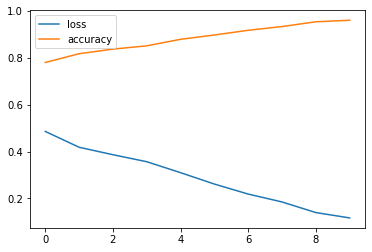

In [ ]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['accuracy'],label='accuracy')
plt.legend()

In [ ]:
y_pred

array([[0.7056989 ],
       [0.99635804],
       [0.96610487],
       ...,
       [0.99917066],
       [0.9973334 ],
       [0.9999732 ]], dtype=float32)

In [ ]:
test_pad[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        121,  670, 1300,   73,   40], dtype=int32)

In [ ]:
y_test[1]

array([1])

In [ ]:
print('shubham')

In [ ]:
print('hi')